Each software projects incorporates a specific technology stack. We aim to identify the **most common technology combinations** across open-source software projects.

['maven', 'docker-compose', 'docker', 'yaml', 'spring']
['docker-compose', 'yaml', 'spring', 'travis', 'docker', 'maven']


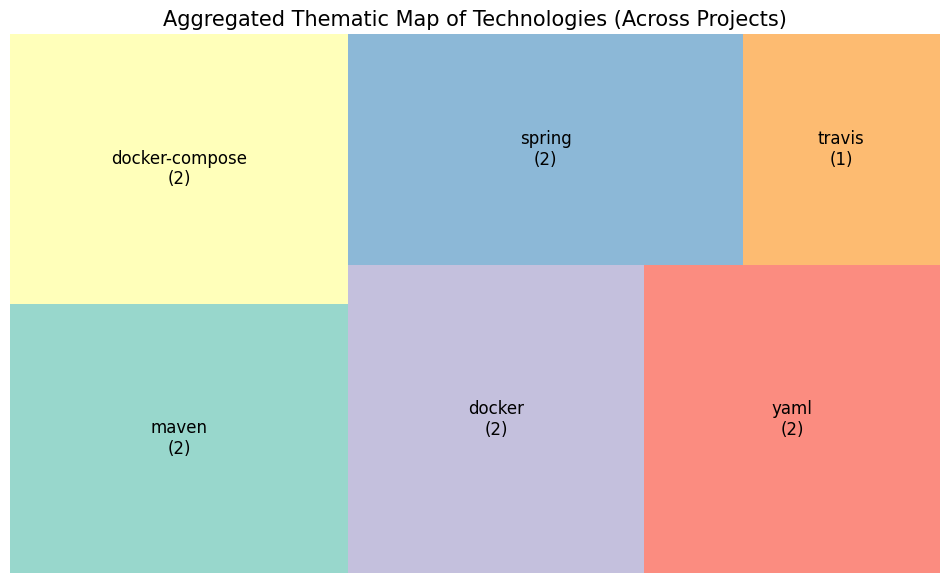

In [ ]:
from typing import List, Dict
import matplotlib.pyplot as plt
import squarify
import json
import glob

def plot_used_technologies(project_files: List):

    aggregated_concepts: Dict[str, int] = {}

    for project_file in project_files:

        with open(project_file, "r", encoding="utf-8") as f:
            data = json.load(f)

            commit_data = data["commit_data"]

            latest_commit = next(filter(lambda commit: commit["is_latest_commit"] == True, commit_data), None)
            concepts = latest_commit["network_data"]["concepts"]
        
            print(concepts)

            for concept in concepts:  
                if concept not in aggregated_concepts:
                    aggregated_concepts[concept] = 1    
                else:   
                    aggregated_concepts[concept] += 1

    # Prepare plot data
    labels = [f"{c}\n({v})" for c, v in aggregated_concepts.items()]
    sizes = list(aggregated_concepts.values())
    colors = plt.cm.Set3.colors[:len(sizes)]

    # Plot
    plt.figure(figsize=(12, 7))
    squarify.plot(sizes=sizes, label=labels, color=colors, alpha=0.9, text_kwargs={'fontsize': 12})
    plt.axis('off')
    plt.title("Aggregated Thematic Map of Technologies (Across Projects)", fontsize=15)
    plt.show()


project_files = glob.glob("../data/microservice_projects/*.json")  
plot_used_technologies(project_files)


In [20]:
from typing import List, Dict, Tuple
import json
import itertools
from collections import Counter

def extract_technology_combinations(project_files: List[str]) -> Dict[Tuple[str, ...], int]:
    """
    Extracts all combinations of concepts (length ≥ 2) from the latest commit of each project.
    Returns a dictionary mapping each combination (as a sorted tuple) to its frequency across projects.
    """
    combo_counts: Dict[Tuple[str, ...], int] = {}

    for project_file in project_files:
        with open(project_file, "r", encoding="utf-8") as f:
            data = json.load(f)

        commit_data = data.get("commit_data", [])
        latest_commit = next((c for c in commit_data if c.get("is_latest_commit")), None)
        if not latest_commit:
            continue

        concepts = sorted(set(latest_commit["network_data"].get("concepts", [])))
        if len(concepts) < 2:
            continue

        for r in range(2, len(concepts) + 1):
            for combo in itertools.combinations(concepts, r):
                combo_counts[combo] = combo_counts.get(combo, 0) + 1

    return combo_counts

# Example usage:
project_files = glob.glob("../data/microservice_projects/*.json")
combos = extract_technology_combinations(project_files)
combos_counter = Counter(combos)
# Print the combinations and their counts
for combo, count in combos_counter.most_common(10):
    print(f"{combo}: {count}")


('docker', 'docker-compose'): 2
('docker', 'maven'): 2
('docker', 'spring'): 2
('docker', 'yaml'): 2
('docker-compose', 'maven'): 2
('docker-compose', 'spring'): 2
('docker-compose', 'yaml'): 2
('maven', 'spring'): 2
('maven', 'yaml'): 2
('spring', 'yaml'): 2


In [ ]:
from upsetplot import UpSet, from_memberships
import matplotlib.pyplot as plt

def plot_technology_combinations(combos_counter: Counter, num_combos: int = 20):
    memberships = []
    counts = []

    for combo, count in combos_counter.most_common(num_combos):
        memberships.append(combo)
        counts.append(count)

    data = from_memberships(memberships, data=counts)

    # Plot
    plt.figure(figsize=(10, 6))
    plot = UpSet(data, show_counts=True).plot()
    plot["intersections"].set_ylabel("# Projects")
    plot["totals"].set_xlabel("Project")
    plt.suptitle("Technology Combinations Across Projects")
    plt.show()